# Fichier consrtuisant les figures du rapport 

> Rédigé par Yannis CHUPIN et Nathan Bourdere Andreou

Définition du nécessaire pour tout le notebook : 

In [1]:
#!/usr/bin/env python3
"""
Notebook d'analyse des résultats PageRank
Génère des visualisations et statistiques pour le rapport
"""

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from collections import defaultdict
import glob

# Configuration du style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ==========================================
# FONCTIONS UTILITAIRES
# ==========================================

DEBUG = False  # Active les détails techniques

def debug_print(*args, **kwargs):
    if DEBUG:
        print(*args, **kwargs)

def load_json_file(filepath):
    """Charge un fichier JSON"""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"⚠️  Erreur lors du chargement de {filepath}: {e}")
        return None

def group_files_by_prefix(directory, extension="json"):
    """
    Groupe les fichiers par préfixe (sans le dernier caractère)
    Ex: file1.json, file2.json, file3.json -> groupe "file"
    """
    files = list(Path(directory).rglob(f"*.{extension}"))
    
    groups = defaultdict(list)
    for file in files:
        # Retirer l'extension et le dernier caractère pour grouper
        stem = file.stem  # nom sans extension
        if len(stem) > 0:
            # Vérifier si le dernier caractère est un chiffre
            if stem[-1].isdigit():
                prefix = stem[:-1]  # Tout sauf le dernier caractère
                groups[prefix].append(file)
            else:
                # Si pas de chiffre, considérer comme un groupe à un seul élément
                groups[stem].append(file)
    
    # Trier les fichiers dans chaque groupe
    for prefix in groups:
        groups[prefix].sort()
    
    return dict(groups)

def load_metadata_group(filepaths):
    """Charge un groupe de fichiers metadata et retourne une liste de dicts"""
    metadata_list = []
    for filepath in filepaths:
        data = load_json_file(filepath)
        if data:
            data['source_file'] = filepath.name
            metadata_list.append(data)
    return metadata_list

def load_csv_with_fallback(filepath):
    """Charge un CSV avec gestion d'erreurs"""
    try:
        # Essayer avec header
        df = pd.read_csv(filepath)
        if df.shape[1] == 1:  # Pas de header détecté
            df = pd.read_csv(filepath, header=None, names=['node', 'rank'])
        return df
    except Exception as e:
        debug_print(f"⚠️  Erreur lors du chargement de {filepath}: {e}")
        return None

# ==========================================
# VISUALISATIONS
# ==========================================

def plot_execution_times(groups_data, title="Temps d'exécution total"):
    fig, ax = plt.subplots(figsize=(14, 6))

    data_for_plot = []
    labels = []

    for group_name, metadata_list in groups_data.items():
        times = [m['total_time_seconds'] for m in metadata_list]
        data_for_plot.append(times)
        labels.append(group_name)

    bp = ax.boxplot(
        data_for_plot,
        labels=labels,
        patch_artist=True,
        showmeans=True,
        meanline=True
    )

    colors = plt.cm.Set3(np.linspace(0, 1, len(data_for_plot)))
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)

    ax.set_ylabel("Temps (secondes)")
    ax.set_xlabel("Configuration")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    return fig

def plot_iteration_times_candlestick(groups_data, title="Temps par itération (Candlestick)"):
    fig, axes = plt.subplots(len(groups_data), 1,
                             figsize=(14, 4 * len(groups_data)),
                             squeeze=False)

    for idx, (group_name, metadata_list) in enumerate(groups_data.items()):
        ax = axes[idx, 0]

        num_iterations = len(metadata_list[0]['iteration_times'])
        iterations = range(1, num_iterations + 1)

        stats = {
            "mean": [],
            "min": [],
            "max": [],
            "q1": [],
            "q3": []
        }

        for i in range(num_iterations):
            values = [m['iteration_times'][i] for m in metadata_list]
            stats["mean"].append(np.mean(values))
            stats["min"].append(np.min(values))
            stats["max"].append(np.max(values))
            stats["q1"].append(np.percentile(values, 25))
            stats["q3"].append(np.percentile(values, 75))

        for i, it in enumerate(iterations):
            # min-max
            ax.plot([it, it], [stats["min"][i], stats["max"][i]],
                    "k-", linewidth=1, alpha=0.5)
            # Q1-Q3
            ax.bar(it, stats["q3"][i] - stats["q1"][i],
                   bottom=stats["q1"][i], width=0.6,
                   color="steelblue", edgecolor="black", alpha=0.6)
            # mean
            ax.plot(it, stats["mean"][i], "ro", markersize=5)

        ax.set_xlabel("Itération")
        ax.set_ylabel("Temps (secondes)")
        ax.set_title(f"{group_name} — Temps par itération")
        ax.set_xticks(iterations)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_metrics_comparison(groups_data, title="Comparaison des métriques"):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    metrics = [
        ("num_nodes", "Nombre de nœuds", axes[0, 0]),
        ("num_links", "Nombre de liens", axes[0, 1]),
        ("total_time_seconds", "Temps total (s)", axes[1, 0]),
        ("avg_iteration_time_seconds", "Temps moyen/itération (s)", axes[1, 1])
    ]

    for key, label, ax in metrics:
        values = []
        labels = []
        errors = []

        for group_name, metadata_list in groups_data.items():
            arr = [m.get(key, 0) for m in metadata_list]
            values.append(np.mean(arr))
            labels.append(group_name)
            errors.append(np.std(arr))

        x = np.arange(len(labels))
        bars = ax.bar(x, values, yerr=errors, capsize=5,
                      alpha=0.75, color="steelblue", edgecolor="black")

        for bar, v in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, v,
                    f"{v:.2f}", ha="center", va="bottom", fontsize=9)

        ax.set_ylabel(label)
        ax.set_xlabel("Configuration")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.grid(True, alpha=0.3, axis="y")

    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

def plot_top_pages(csv_groups, top_n=20, title="Top Pages par PageRank"):
    """
    Barplot horizontal des top pages pour chaque groupe.
    Filtre automatiquement les CSV ne contenant pas les colonnes 'node' et 'rank'.
    """
    num_groups = len(csv_groups)
    fig, axes = plt.subplots(num_groups, 1,
                             figsize=(14, 6 * num_groups),
                             squeeze=False)

    required_cols = {'node', 'rank'}

    for idx, (group_name, csv_files) in enumerate(csv_groups.items()):
        ax = axes[idx, 0]

        all_ranks = []

        # Charger les CSV et filtrer ceux sans 'node' / 'rank'
        for csv_file in csv_files:
            df = load_csv_with_fallback(csv_file)

            if df is None:
                debug_print(f"⏭️  Ignoré (lecture impossible) : {csv_file}")
                continue

            # Vérification des colonnes
            if not required_cols.issubset(df.columns):
                debug_print(f"⏭️  Ignoré (colonnes manquantes) : {csv_file}")
                debug_print(f"    Colonnes trouvées : {list(df.columns)}")
                continue

            # On ne garde que node + rank
            all_ranks.append(df[['node', 'rank']])

        # Si aucun CSV valable → groupe ignoré
        if not all_ranks:
            debug_print(f"⚠️ Aucun CSV valide pour le groupe '{group_name}'.")
            ax.set_title(f"{group_name} — Aucune donnée valide")
            ax.axis('off')
            continue

        # Fusion + moyenne
        merged = (
            pd.concat(all_ranks)
            .groupby('node')['rank']
            .mean()
            .reset_index()
            .sort_values('rank', ascending=False)
            .head(top_n)
        )

        # Plot
        colors = plt.cm.viridis(np.linspace(0, 1, len(merged)))
        bars = ax.barh(range(len(merged)), merged['rank'], color=colors)

        ax.set_yticks(range(len(merged)))
        ax.set_yticklabels(merged['node'], fontsize=9)
        ax.set_xlabel('PageRank Score')
        ax.set_title(f'{group_name} - Top {top_n} Pages')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')

        # Ajout des valeurs
        for bar, val in zip(bars, merged['rank']):
            ax.text(
                bar.get_width(),
                bar.get_y() + bar.get_height() / 2.,
                f' {val:.4f}',
                ha='left',
                va='center',
                fontsize=8
            )

    plt.tight_layout()
    return fig


def plot_rank_distribution(csv_groups, title="Distribution des PageRank"):
    """
    Histogrammes et boxplots de la distribution des ranks.
    Filtre automatiquement les CSV ne contenant pas les colonnes 'node' et 'rank'.
    """
    required_cols = {'node', 'rank'}

    num_groups = len(csv_groups)
    fig, axes = plt.subplots(num_groups, 2, 
                             figsize=(16, 5 * num_groups),
                             squeeze=False)

    for idx, (group_name, csv_files) in enumerate(csv_groups.items()):
        all_ranks = []

        # Charger et filtrer les CSV
        for csv_file in csv_files:
            df = load_csv_with_fallback(csv_file)

            if df is None:
                debug_print(f"⏭️  Ignoré (lecture impossible) : {csv_file}")
                continue

            if not required_cols.issubset(df.columns):
                debug_print(f"⏭️  Ignoré (colonnes manquantes) : {csv_file}")
                debug_print(f"    Colonnes trouvées : {list(df.columns)}")
                continue

            # Accumuler les ranks
            all_ranks.extend(df['rank'].values)

        # Aucun CSV correct dans ce groupe ?
        if not all_ranks:
            debug_print(f"⚠️ Aucun CSV valide pour le groupe '{group_name}'.")
            ax1 = axes[idx, 0]
            ax2 = axes[idx, 1]
            ax1.set_title(f"{group_name} — Aucune donnée valide")
            ax2.set_title(f"{group_name} — Aucune donnée valide")
            ax1.axis('off')
            ax2.axis('off')
            continue

        # --- HISTOGRAMME ---
        ax1 = axes[idx, 0]
        ax1.hist(all_ranks, bins=50, alpha=0.7,
                 color='steelblue', edgecolor='black')
        ax1.set_xlabel('PageRank Score')
        ax1.set_ylabel('Fréquence')
        ax1.set_title(f'{group_name} - Distribution (Histogramme)')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)

        # --- BOX PLOT ---
        ax2 = axes[idx, 1]
        bp = ax2.boxplot([all_ranks], vert=True, patch_artist=True,
                         labels=[group_name], showmeans=True)
        bp['boxes'][0].set_facecolor('lightblue')
        ax2.set_ylabel('PageRank Score')
        ax2.set_title(f'{group_name} - Distribution (BoxPlot)')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def generate_summary_table(groups_data):
    """
    Génère un DataFrame résumé avec statistiques par groupe
    """
    summary = []
    
    for group_name, metadata_list in groups_data.items():
        num_runs = len(metadata_list)
        
        times = [m['total_time_seconds'] for m in metadata_list]
        nodes = [m['num_nodes'] for m in metadata_list]
        links = [m['num_links'] for m in metadata_list]
        avg_iter_times = [m['avg_iteration_time_seconds'] for m in metadata_list]
        
        summary.append({
            'Configuration': group_name,
            'Nombre de runs': num_runs,
            'Nœuds': f"{np.mean(nodes):.0f} ± {np.std(nodes):.0f}",
            'Liens': f"{np.mean(links):.0f} ± {np.std(links):.0f}",
            'Temps total (s)': f"{np.mean(times):.2f} ± {np.std(times):.2f}",
            'Temps moyen/iter (s)': f"{np.mean(avg_iter_times):.2f} ± {np.std(avg_iter_times):.2f}",
            'Min temps (s)': f"{np.min(times):.2f}",
            'Max temps (s)': f"{np.max(times):.2f}"
        })
    
    return pd.DataFrame(summary)

def print_table(df):
    """Affichage console propre du tableau sans dépendance externe."""
    
    # Convertir tout en string
    df_str = df.astype(str)

    # Déterminer la largeur max de chaque colonne
    col_widths = {
        col: max(df_str[col].apply(len).max(), len(col))
        for col in df.columns
    }

    # Ligne d’en-tête
    header = " | ".join(col.ljust(col_widths[col]) for col in df.columns)

    # Séparateur
    separator = "-+-".join("-" * col_widths[col] for col in df.columns)

    # Lignes du tableau
    rows = []
    for _, row in df_str.iterrows():
        row_str = " | ".join(
            row[col].ljust(col_widths[col]) for col in df.columns
        )
        rows.append(row_str)

    # Affichage final
    print(header)
    print(separator)
    for r in rows:
        print(r)


## 1. Test avec un échantillon à 10% prélevé avec la méthode `"vertex-cut"`

ANALYSE DES RÉSULTATS PAGERANK

📋 Génération du tableau récapitulatif...

TABLEAU RÉCAPITULATIF
Configuration    | Nombre de runs | Nœuds      | Liens      | Temps total (s) | Temps moyen/iter (s) | Min temps (s) | Max temps (s)
-----------------+----------------+------------+------------+-----------------+----------------------+---------------+--------------
meta_sample_2_df | 3              | 278296 ± 0 | 360474 ± 0 | 78.16 ± 5.48    | 0.27 ± 0.02          | 74.28         | 85.91        
meta_sample_4_df | 3              | 278296 ± 0 | 360474 ± 0 | 79.25 ± 7.81    | 0.25 ± 0.01          | 68.36         | 86.30        
meta_sample_6_df | 3              | 278296 ± 0 | 360474 ± 0 | 80.75 ± 4.65    | 0.25 ± 0.02          | 74.28         | 85.01        
💾 Tableau HTML sauvegardé : ./sample/summary_table.html

📊 Génération des visualisations...


C:\Users\Yannis\AppData\Local\Temp\ipykernel_41344\3248663206.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\Yannis\AppData\Local\Temp\ipykernel_41344\3248663206.py:341: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([all_ranks], vert=True, patch_artist=True,
C:\Users\Yannis\AppData\Local\Temp\ipykernel_41344\3248663206.py:341: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([all_ranks], vert=True, patch_artist=True,
C:\Users\Yannis\AppData\Local\Temp\ipykernel_41344\3248663206.py:341: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has 


✅ 3 visualisations générées dans : ./sample/

ANALYSE TERMINÉE


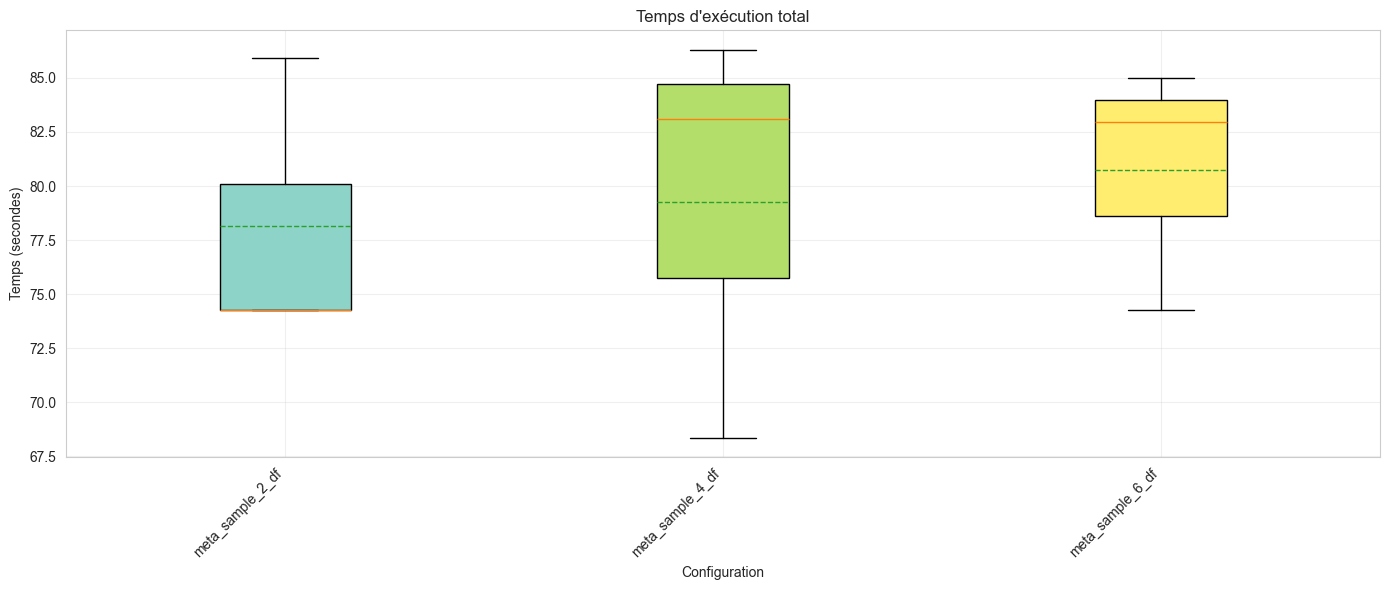

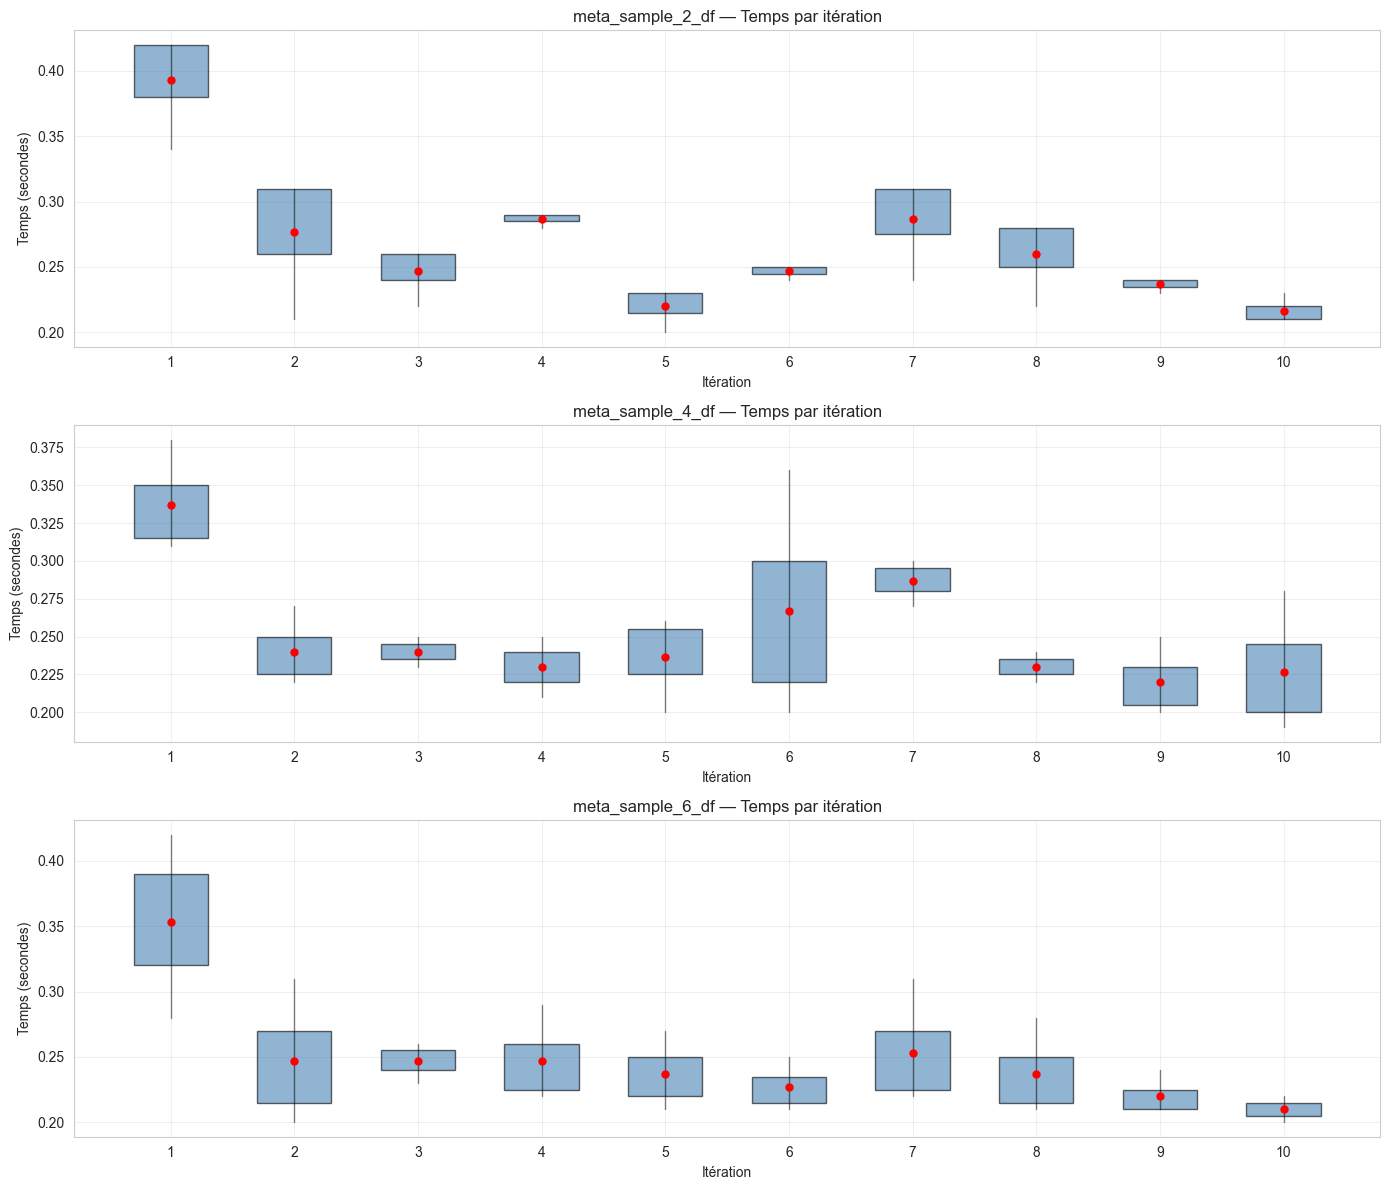

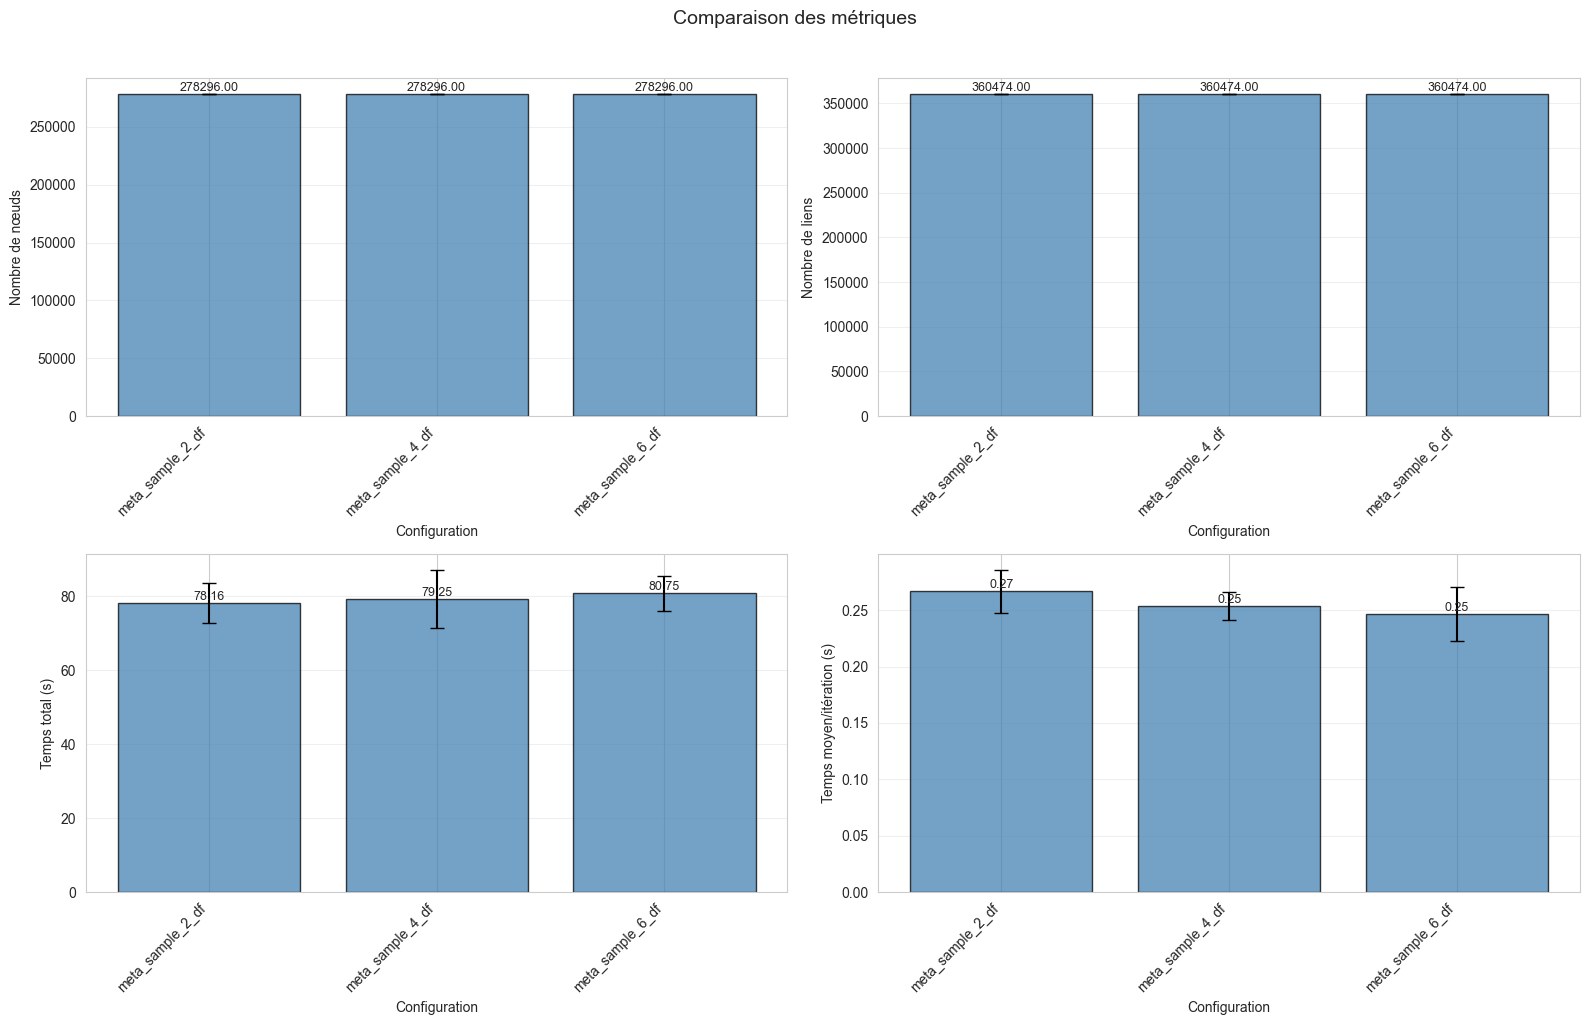

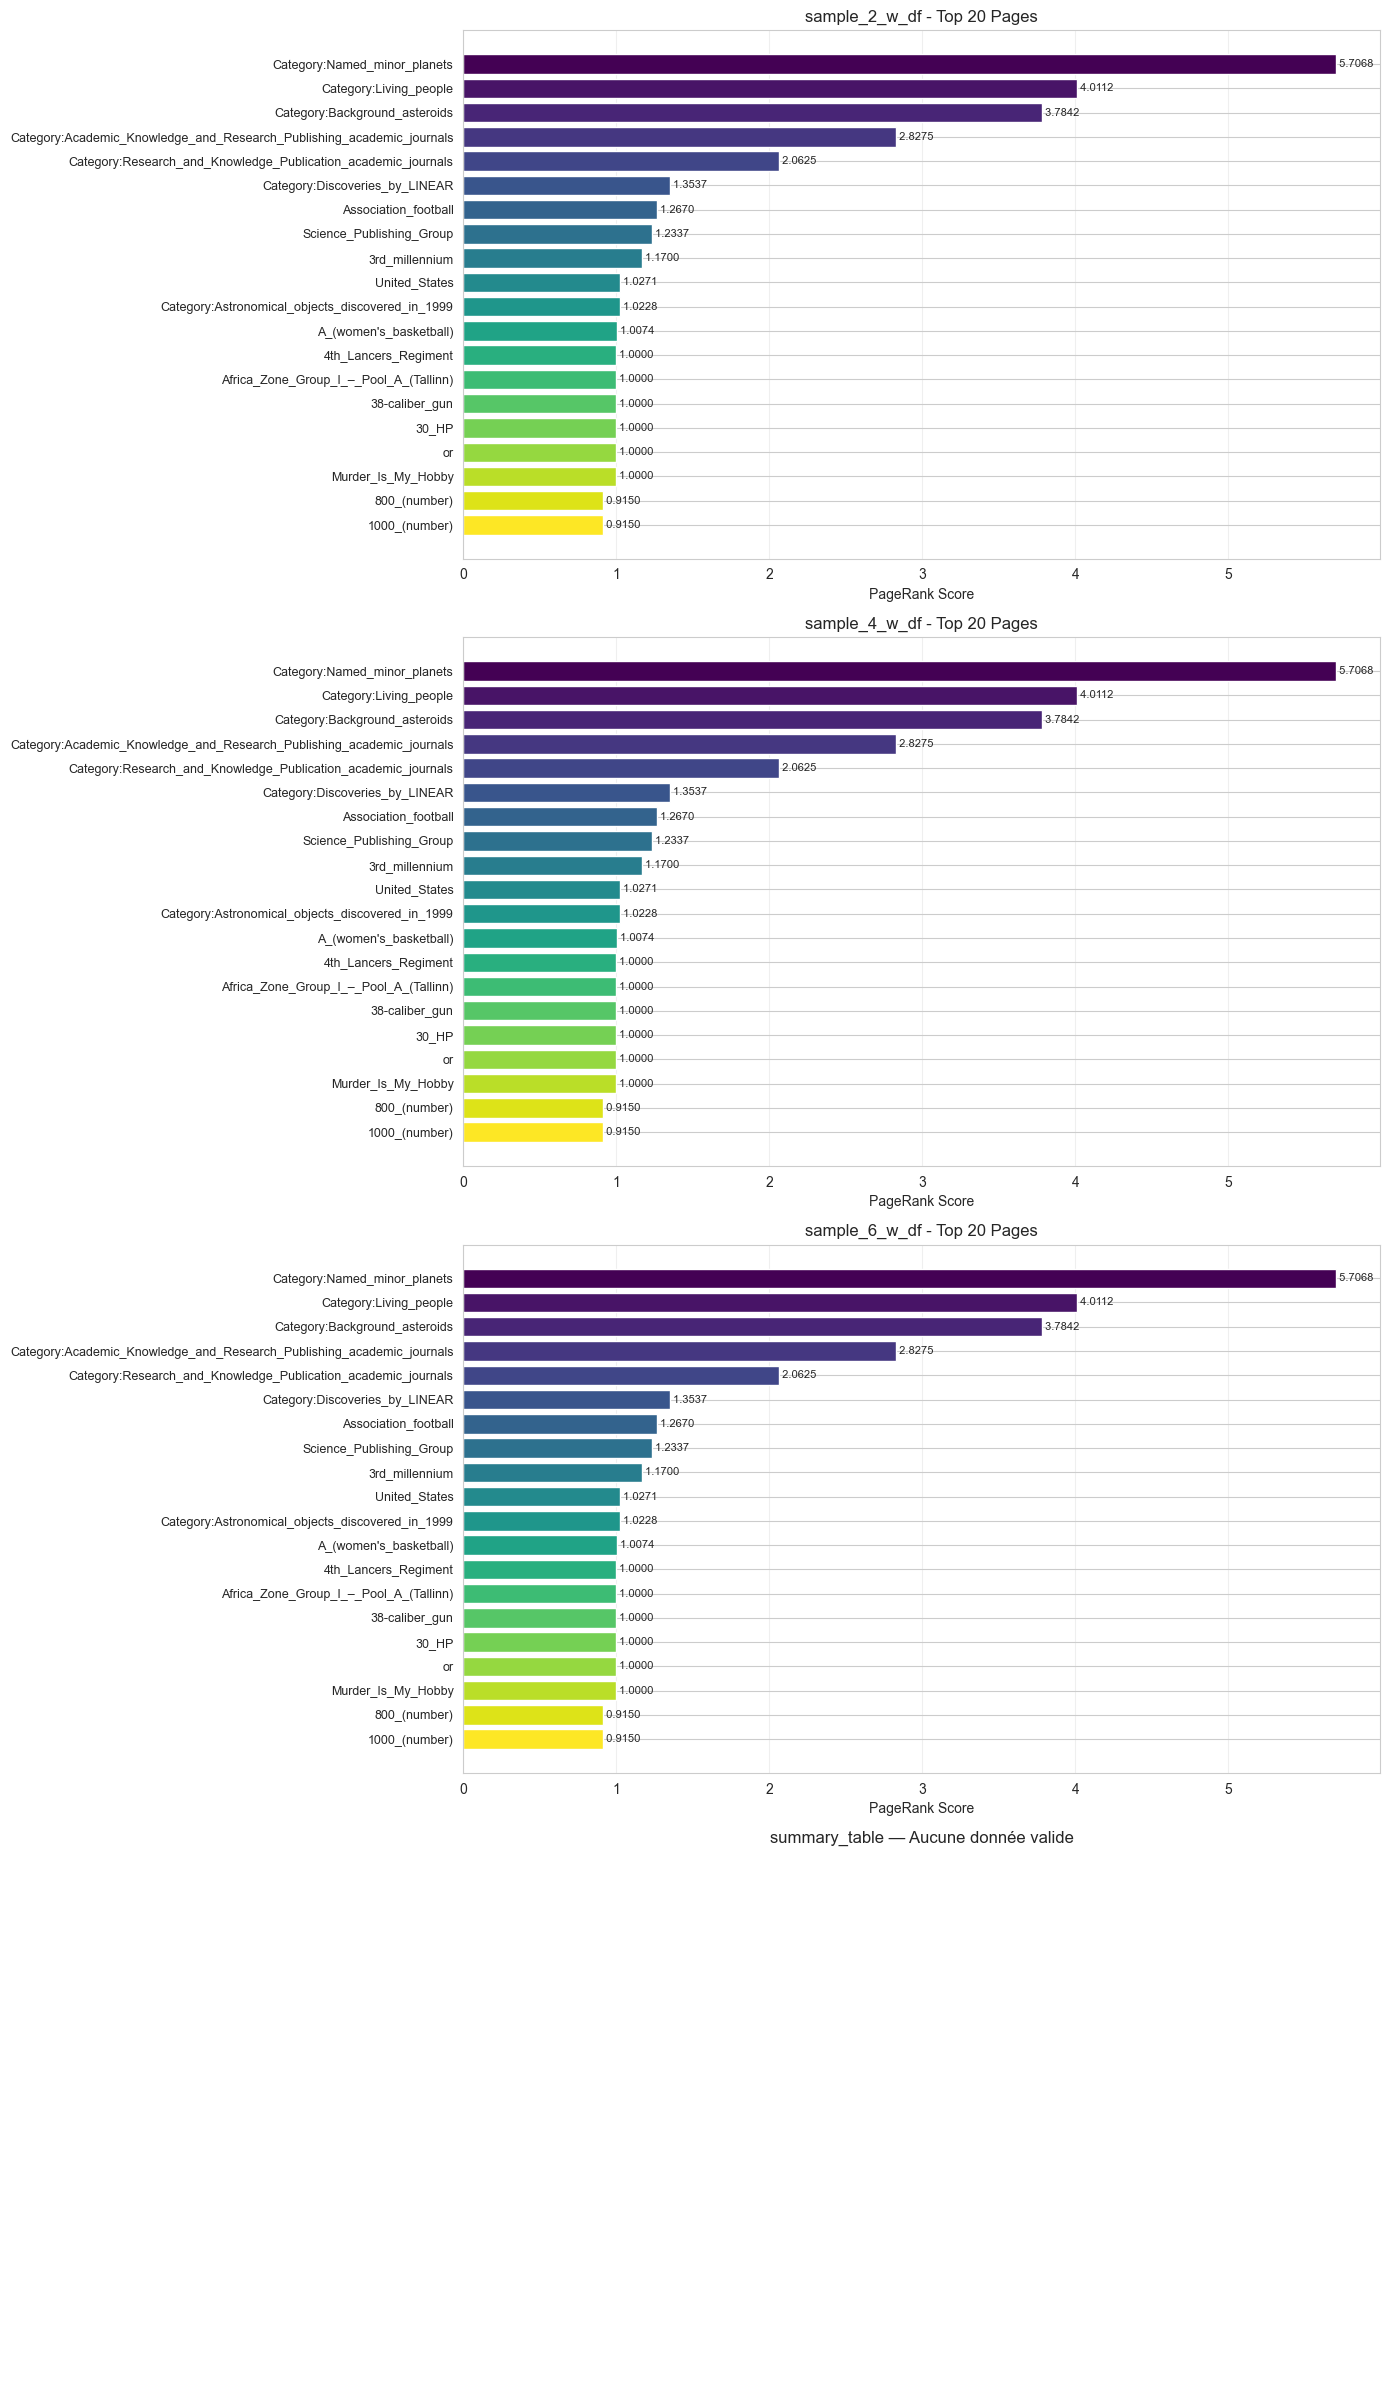

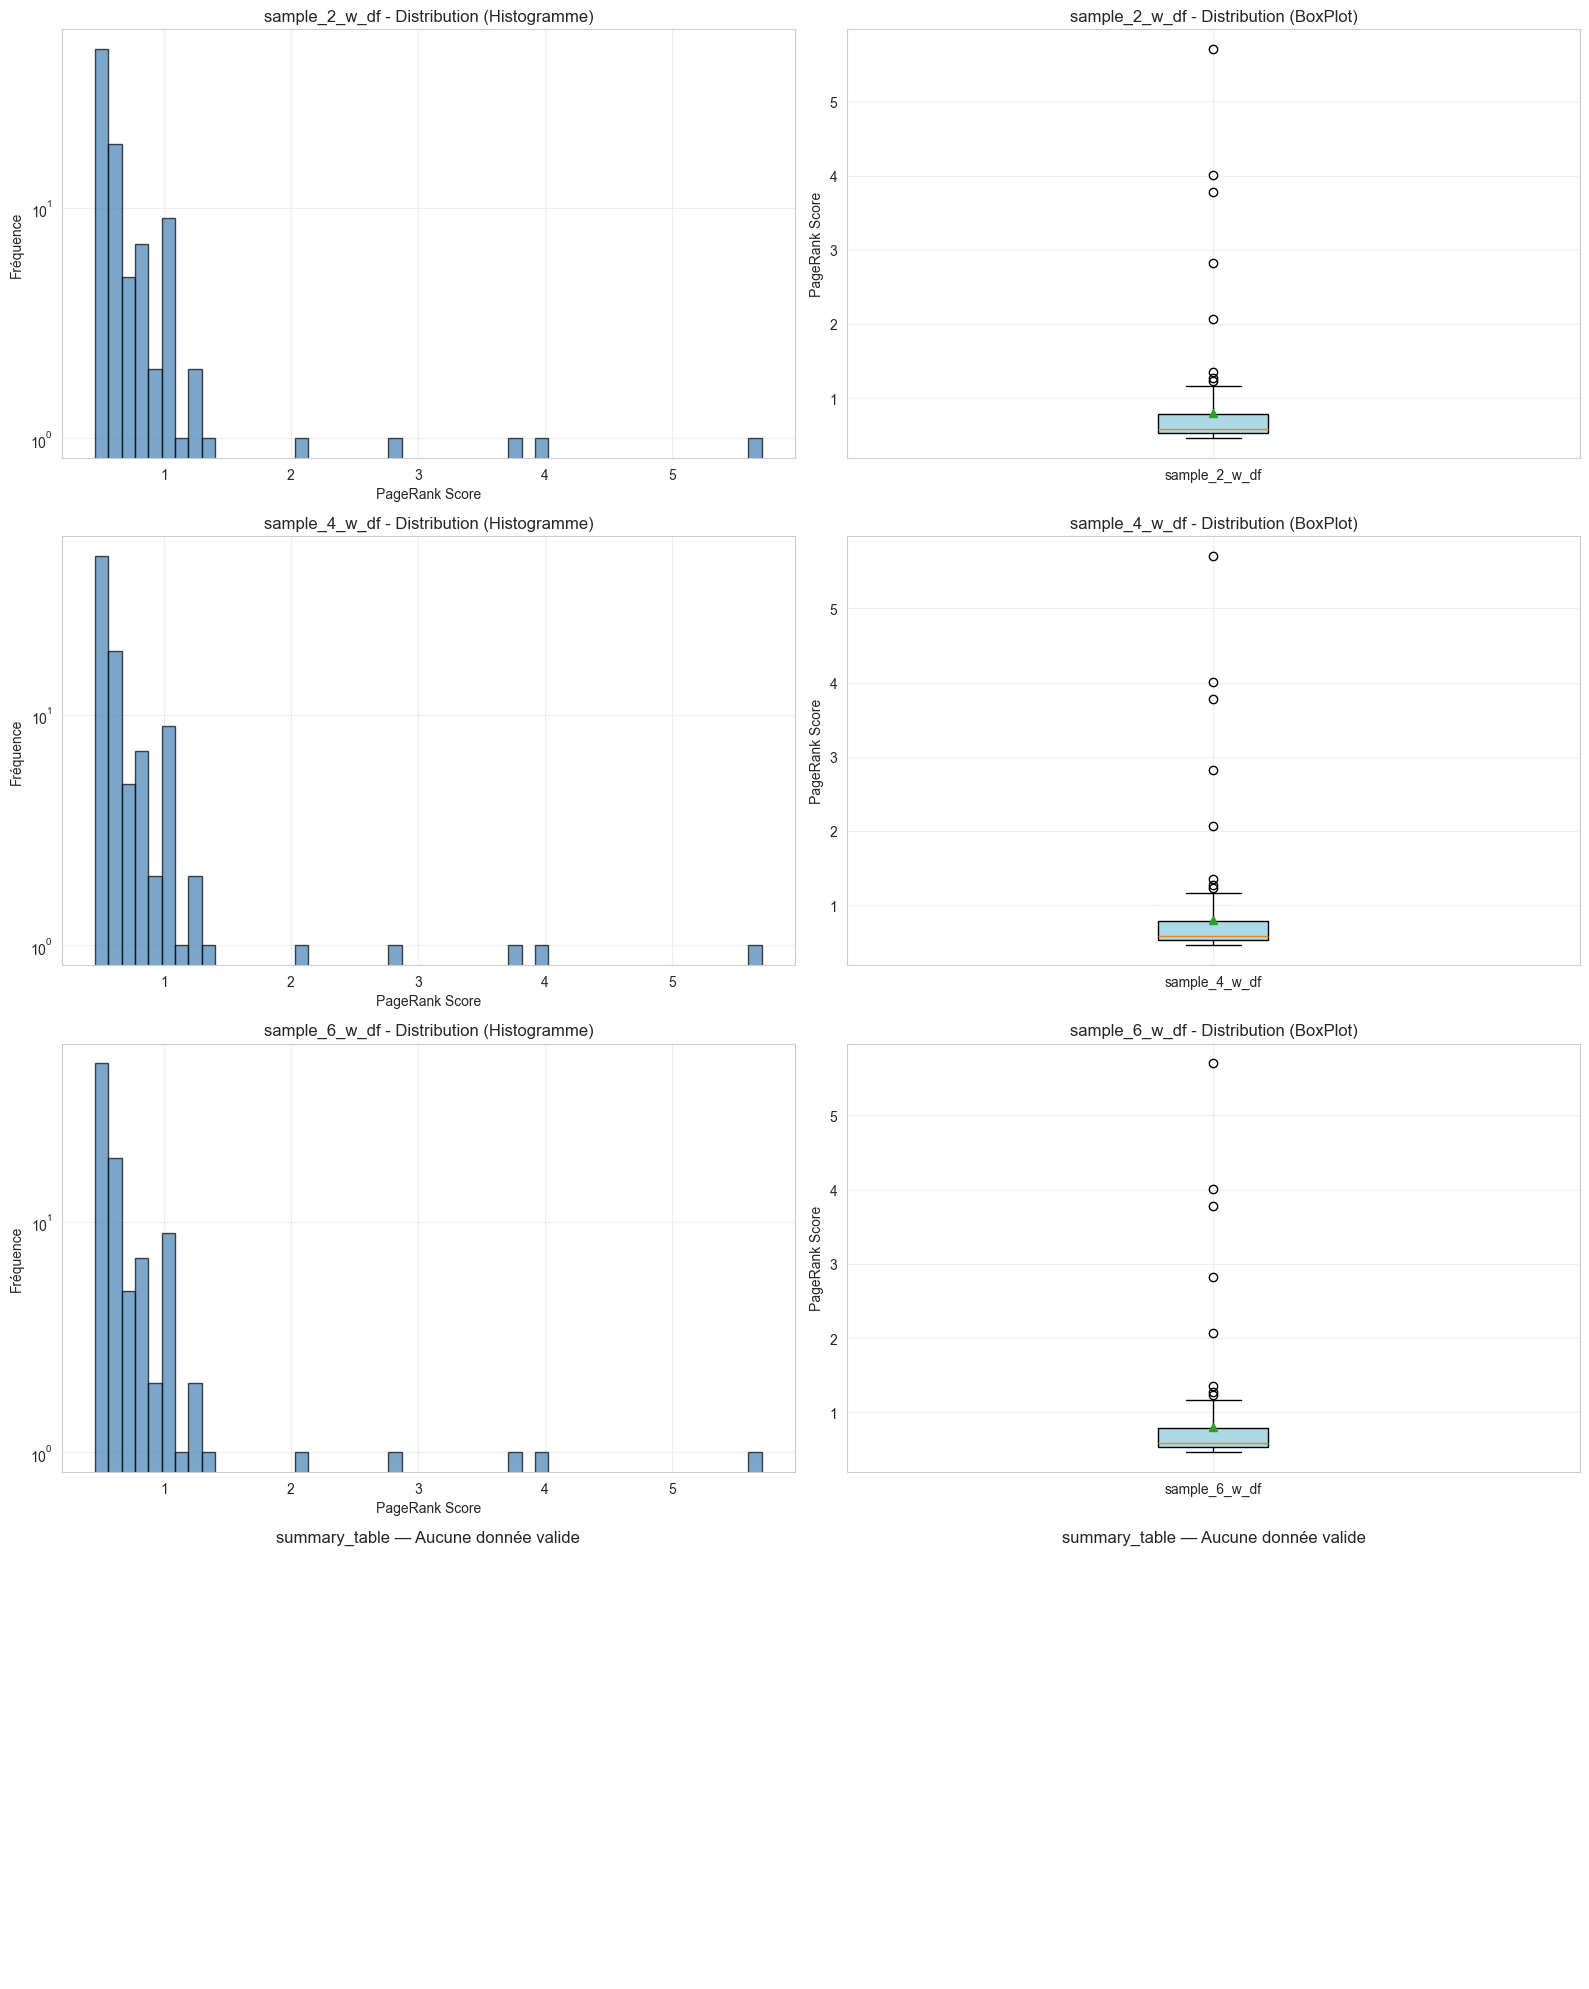

In [2]:
# ==========================================
# CONFIGURATION
# ==========================================

# Répertoire contenant les résultats
RESULTS_DIR = "./sample"  # Adapter selon la structure


# ==========================================
# MAIN EXECUTION
# ==========================================

def main():
    print("=" * 60)
    print("ANALYSE DES RÉSULTATS PAGERANK")
    print("=" * 60)
    
    # 1. JSON
    debug_print(f"\n📂 Recherche des fichiers dans : {RESULTS_DIR}")
    json_groups = group_files_by_prefix(RESULTS_DIR, "json")
    debug_print(json_groups)
    
    debug_print(f"\n✅ {len(json_groups)} groupes de métadonnées détectés :")
    for group_name, files in json_groups.items():
        debug_print(f"   - {group_name}: {len(files)} fichier(s)")
    
    # 2. Chargement
    debug_print("\n📊 Chargement des métadonnées...")
    groups_data = {}
    for group_name, files in json_groups.items():
        metadata_list = load_metadata_group(files)
        if metadata_list:
            groups_data[group_name] = metadata_list
            debug_print(f"   ✓ {group_name}: {len(metadata_list)} run(s) chargé(s)")
    
    if not groups_data:
        print("❌ Aucune métadonnée valide trouvée !")
        return
    
    # 3. CSV
    debug_print(f"\n📂 Recherche des CSV...")
    csv_groups = group_files_by_prefix(RESULTS_DIR, "csv")
    debug_print(f"✅ {len(csv_groups)} groupes de CSV détectés")
    
    # 4. Tableau récapitulatif
    print("\n📋 Génération du tableau récapitulatif...")
    summary_df = generate_summary_table(groups_data)
    print("\n" + "=" * 60)
    print("TABLEAU RÉCAPITULATIF")
    print("=" * 60)
    print_table(summary_df)
    print("=" * 60)
    
    # 5. Export HTML
    html = summary_df.to_html(index=False, justify='center', border=0)
    html_styled = f"""
    <html>
    <head> ... (inchangé) ... </head>
    <body>
    <h2 style="text-align:center;">Résumé des exécutions PageRank</h2>
    {html}
    </body>
    </html>
    """
    with open(f"{RESULTS_DIR}/summary_table.html", "w", encoding="utf-8") as f:
        f.write(html_styled)
    
    print(f"💾 Tableau HTML sauvegardé : {RESULTS_DIR}/summary_table.html")
    
    # 6. Graphiques
    print("\n📊 Génération des visualisations...")
    figures = []
    
    fig1 = plot_execution_times(groups_data)
    fig1.savefig(f"{RESULTS_DIR}/plot_execution_times.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_execution_times.png")
    figures.append(("Temps d'exécution", "plot_execution_times.png"))
    
    fig2 = plot_iteration_times_candlestick(groups_data)
    fig2.savefig(f"{RESULTS_DIR}/plot_iteration_candlestick.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_iteration_candlestick.png")
    figures.append(("Temps par itération", "plot_iteration_candlestick.png"))
    
    fig3 = plot_metrics_comparison(groups_data)
    fig3.savefig(f"{RESULTS_DIR}/plot_metrics_comparison.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_metrics_comparison.png")
    figures.append(("Métriques", "plot_metrics_comparison.png"))
    
    if csv_groups:
        fig4 = plot_top_pages(csv_groups)
        fig4.savefig(f"{RESULTS_DIR}/plot_top_pages.png", dpi=300, bbox_inches='tight')
        debug_print("   ✓ plot_top_pages.png")
        
        fig5 = plot_rank_distribution(csv_groups)
        fig5.savefig(f"{RESULTS_DIR}/plot_rank_distribution.png", dpi=300, bbox_inches='tight')
        debug_print("   ✓ plot_rank_distribution.png")
    
    print(f"\n✅ {len(figures)} visualisations générées dans : {RESULTS_DIR}/")
    print("\n" + "=" * 60)
    print("ANALYSE TERMINÉE")
    print("=" * 60)


if __name__ == "__main__":
    main()

### Analyse des figures & résultats

Quelques explications ...

Note : Google a signalé une latence forte : 

## 2. Test sur la totalité avec DF

In [3]:
# ==========================================
# CONFIGURATION
# ==========================================

# Répertoire contenant les résultats
RESULTS_DIR = "./fullDF"  # Adapter selon la structure


# ==========================================
# MAIN EXECUTION
# ==========================================

def main():
    print("=" * 60)
    print("ANALYSE DES RÉSULTATS PAGERANK")
    print("=" * 60)
    
    # 1. JSON
    debug_print(f"\n📂 Recherche des fichiers dans : {RESULTS_DIR}")
    json_groups = group_files_by_prefix(RESULTS_DIR, "json")
    debug_print(json_groups)
    
    debug_print(f"\n✅ {len(json_groups)} groupes de métadonnées détectés :")
    for group_name, files in json_groups.items():
        debug_print(f"   - {group_name}: {len(files)} fichier(s)")
    
    # 2. Chargement
    debug_print("\n📊 Chargement des métadonnées...")
    groups_data = {}
    for group_name, files in json_groups.items():
        metadata_list = load_metadata_group(files)
        if metadata_list:
            groups_data[group_name] = metadata_list
            debug_print(f"   ✓ {group_name}: {len(metadata_list)} run(s) chargé(s)")
    
    if not groups_data:
        print("❌ Aucune métadonnée valide trouvée !")
        return
    
    # 3. CSV
    debug_print(f"\n📂 Recherche des CSV...")
    csv_groups = group_files_by_prefix(RESULTS_DIR, "csv")
    debug_print(f"✅ {len(csv_groups)} groupes de CSV détectés")
    
    # 4. Tableau récapitulatif
    print("\n📋 Génération du tableau récapitulatif...")
    summary_df = generate_summary_table(groups_data)
    print("\n" + "=" * 60)
    print("TABLEAU RÉCAPITULATIF")
    print("=" * 60)
    print_table(summary_df)
    print("=" * 60)
    
    # 5. Export HTML
    html = summary_df.to_html(index=False, justify='center', border=0)
    html_styled = f"""
    <html>
    <head> ... (inchangé) ... </head>
    <body>
    <h2 style="text-align:center;">Résumé des exécutions PageRank</h2>
    {html}
    </body>
    </html>
    """
    with open(f"{RESULTS_DIR}/summary_table.html", "w", encoding="utf-8") as f:
        f.write(html_styled)
    
    print(f"💾 Tableau HTML sauvegardé : {RESULTS_DIR}/summary_table.html")
    
    # 6. Graphiques
    print("\n📊 Génération des visualisations...")
    figures = []
    
    fig1 = plot_execution_times(groups_data)
    fig1.savefig(f"{RESULTS_DIR}/plot_execution_times.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_execution_times.png")
    figures.append(("Temps d'exécution", "plot_execution_times.png"))
    
    fig2 = plot_iteration_times_candlestick(groups_data)
    fig2.savefig(f"{RESULTS_DIR}/plot_iteration_candlestick.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_iteration_candlestick.png")
    figures.append(("Temps par itération", "plot_iteration_candlestick.png"))
    
    fig3 = plot_metrics_comparison(groups_data)
    fig3.savefig(f"{RESULTS_DIR}/plot_metrics_comparison.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_metrics_comparison.png")
    figures.append(("Métriques", "plot_metrics_comparison.png"))
    
    if csv_groups:
        fig4 = plot_top_pages(csv_groups)
        fig4.savefig(f"{RESULTS_DIR}/plot_top_pages.png", dpi=300, bbox_inches='tight')
        debug_print("   ✓ plot_top_pages.png")
        
        fig5 = plot_rank_distribution(csv_groups)
        fig5.savefig(f"{RESULTS_DIR}/plot_rank_distribution.png", dpi=300, bbox_inches='tight')
        debug_print("   ✓ plot_rank_distribution.png")
    
    print(f"\n✅ {len(figures)} visualisations générées dans : {RESULTS_DIR}/")
    print("\n" + "=" * 60)
    print("ANALYSE TERMINÉE")
    print("=" * 60)


if __name__ == "__main__":
    main()

ANALYSE DES RÉSULTATS PAGERANK
❌ Aucune métadonnée valide trouvée !


### Analyse des figures & résultats

Quelques explications ...

## 3. Test sur la totalité avec RDD

In [4]:
# ==========================================
# CONFIGURATION
# ==========================================

# Répertoire contenant les résultats
RESULTS_DIR = "./fullRDD"  # Adapter selon la structure


# ==========================================
# MAIN EXECUTION
# ==========================================

def main():
    print("=" * 60)
    print("ANALYSE DES RÉSULTATS PAGERANK")
    print("=" * 60)
    
    # 1. JSON
    debug_print(f"\n📂 Recherche des fichiers dans : {RESULTS_DIR}")
    json_groups = group_files_by_prefix(RESULTS_DIR, "json")
    debug_print(json_groups)
    
    debug_print(f"\n✅ {len(json_groups)} groupes de métadonnées détectés :")
    for group_name, files in json_groups.items():
        debug_print(f"   - {group_name}: {len(files)} fichier(s)")
    
    # 2. Chargement
    debug_print("\n📊 Chargement des métadonnées...")
    groups_data = {}
    for group_name, files in json_groups.items():
        metadata_list = load_metadata_group(files)
        if metadata_list:
            groups_data[group_name] = metadata_list
            debug_print(f"   ✓ {group_name}: {len(metadata_list)} run(s) chargé(s)")
    
    if not groups_data:
        print("❌ Aucune métadonnée valide trouvée !")
        return
    
    # 3. CSV
    debug_print(f"\n📂 Recherche des CSV...")
    csv_groups = group_files_by_prefix(RESULTS_DIR, "csv")
    debug_print(f"✅ {len(csv_groups)} groupes de CSV détectés")
    
    # 4. Tableau récapitulatif
    print("\n📋 Génération du tableau récapitulatif...")
    summary_df = generate_summary_table(groups_data)
    print("\n" + "=" * 60)
    print("TABLEAU RÉCAPITULATIF")
    print("=" * 60)
    print_table(summary_df)
    print("=" * 60)
    
    # 5. Export HTML
    html = summary_df.to_html(index=False, justify='center', border=0)
    html_styled = f"""
    <html>
    <head> ... (inchangé) ... </head>
    <body>
    <h2 style="text-align:center;">Résumé des exécutions PageRank</h2>
    {html}
    </body>
    </html>
    """
    with open(f"{RESULTS_DIR}/summary_table.html", "w", encoding="utf-8") as f:
        f.write(html_styled)
    
    print(f"💾 Tableau HTML sauvegardé : {RESULTS_DIR}/summary_table.html")
    
    # 6. Graphiques
    print("\n📊 Génération des visualisations...")
    figures = []
    
    fig1 = plot_execution_times(groups_data)
    fig1.savefig(f"{RESULTS_DIR}/plot_execution_times.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_execution_times.png")
    figures.append(("Temps d'exécution", "plot_execution_times.png"))
    
    fig2 = plot_iteration_times_candlestick(groups_data)
    fig2.savefig(f"{RESULTS_DIR}/plot_iteration_candlestick.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_iteration_candlestick.png")
    figures.append(("Temps par itération", "plot_iteration_candlestick.png"))
    
    fig3 = plot_metrics_comparison(groups_data)
    fig3.savefig(f"{RESULTS_DIR}/plot_metrics_comparison.png", dpi=300, bbox_inches='tight')
    debug_print("   ✓ plot_metrics_comparison.png")
    figures.append(("Métriques", "plot_metrics_comparison.png"))
    
    if csv_groups:
        fig4 = plot_top_pages(csv_groups)
        fig4.savefig(f"{RESULTS_DIR}/plot_top_pages.png", dpi=300, bbox_inches='tight')
        debug_print("   ✓ plot_top_pages.png")
        
        fig5 = plot_rank_distribution(csv_groups)
        fig5.savefig(f"{RESULTS_DIR}/plot_rank_distribution.png", dpi=300, bbox_inches='tight')
        debug_print("   ✓ plot_rank_distribution.png")
    
    print(f"\n✅ {len(figures)} visualisations générées dans : {RESULTS_DIR}/")
    print("\n" + "=" * 60)
    print("ANALYSE TERMINÉE")
    print("=" * 60)


if __name__ == "__main__":
    main()

ANALYSE DES RÉSULTATS PAGERANK
❌ Aucune métadonnée valide trouvée !


### Analyse des figures & résultats

Quelques explications ...

## 4. Conclusion

lorem ipsum